In [1]:
import sqlite3
import pandas as pd

In [2]:
con = sqlite3.connect('db')

In [3]:
df = pd.read_csv('german_credit_augmented.csv')
df.head(5)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [4]:
df['contract_dt'] = pd.to_datetime(df['contract_dt'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# теперь зальем нашу таблицу в базу данных

df.to_sql('german_credit', con, index=False, if_exists='replace')

1000

**Чтобы облегчить обращение к таблице напишем функцию select** 

In [6]:
def select(sql):
    return pd.read_sql(sql, con)

In [7]:
# для join в каждой таблице должен быть ключ, который связывает таблицы друг с другом, это просто столбец какой-то

In [8]:
# для эксперимента создам таблички, по которым будем тренироваться

users = pd.DataFrame({'id' : [1, 2, 3, 4, 5], 'name' : ['Alex', 'Gleb', 'Ramazan', 'Victor', 'Danila']})
users

,id,name
0,1,Alex
1,2,Gleb
2,3,Ramazan
3,4,Victor
4,5,Danila


In [9]:
items = pd.DataFrame({'user_id' : [1, 3, 4, 5], 
                      'item_name' : ['gold', 'hleb', 'shugar', 'oil'],
                      'value' : [100, 5, 10, 15]})

items

,user_id,item_name,value
0,1,gold,100
1,3,hleb,5
2,4,shugar,10
3,5,oil,15


In [10]:
# теперь зальем эти таблицы в базу данных

users.to_sql('users', con, index=False, if_exists='replace')

items.to_sql('items', con, index=False, if_exists='replace')

4

In [11]:
# мы хотим в первую таблицу подянуть информацию о второй таблице, у нас есть номера совпадающие уникальные

**САМЫЙ БЕЗОПАСНЫЙ И ДЕФОЛТНЫЙ JOIN - LEFT JOIN, КОТОРЫЙ НЕ ТЕРЯЕТ СТРОКИ**

в результате LEFT JOIN ничего и никогда не пропадет

# LEFT JOIN

**остаются все строки с левой таблицы и все, что нашлось справа по ключу**

on - это условие, а связка таблиц идет через алиасы, вот почему это удобно!

In [12]:
sql = ''' select * from users as t
left join items as i 
on t.id = i.user_id
'''

select(sql)

,id,name,user_id,item_name,value
0,1,Alex,1.0,gold,100.0
1,2,Gleb,NaN,None,NaN
2,3,Ramazan,3.0,hleb,5.0
3,4,Victor,4.0,shugar,10.0
4,5,Danila,5.0,oil,15.0


# INNER JOIN

In [13]:
# INNER JOIN, в результате его берутся на вывод только те строки, по которым что-то нашлось!!!


sql = '''select * from users as t
inner join items as i
on t.id = i.user_id'''

select(sql)

,id,name,user_id,item_name,value
0,1,Alex,1,gold,100
1,3,Ramazan,3,hleb,5
2,4,Victor,4,shugar,10
3,5,Danila,5,oil,15


# поведение JOIN с дубликатами

In [14]:
# добавим дубликаты в user_id, который является ключом
# также добавлю дубликат в item_name

In [15]:
# для эксперимента создам таблички, по которым будем тренироваться

users = pd.DataFrame({'id' : [1, 2, 3, 4, 5], 'name' : ['Alex', 'Gleb', 'Ramazan', 'Victor', 'Danila']})
users

,id,name
0,1,Alex
1,2,Gleb
2,3,Ramazan
3,4,Victor
4,5,Danila


In [16]:
items = pd.DataFrame({'user_id' : [1, 3, 4, 5, 3], 
                      'item_name' : ['gold', 'hleb', 'shugar', 'oil', 'wine'],
                      'value' : [100, 5, 10, 15, 20]})

items

,user_id,item_name,value
0,1,gold,100
1,3,hleb,5
2,4,shugar,10
3,5,oil,15
4,3,wine,20


In [17]:
# теперь зальем эти таблицы в базу данных

users.to_sql('users', con, index=False, if_exists='replace')

items.to_sql('items', con, index=False, if_exists='replace')

5

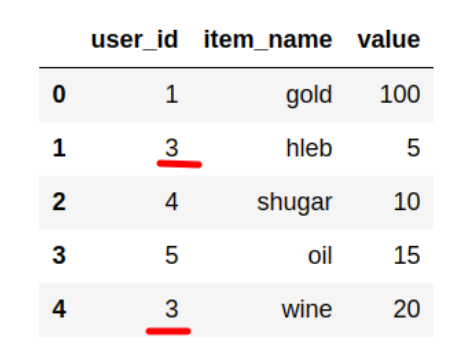

**посмотрим на поведение inner join и left join**

In [18]:
sql = '''select * from users as t
left join items as i
on t.id = i.user_id'''

select(sql)
# sql вывел все, что нашлось, строк может стать больше

,id,name,user_id,item_name,value
0,1,Alex,1.0,gold,100.0
1,2,Gleb,NaN,None,NaN
2,3,Ramazan,3.0,hleb,5.0
3,3,Ramazan,3.0,wine,20.0
4,4,Victor,4.0,shugar,10.0
5,5,Danila,5.0,oil,15.0


In [19]:
sql = '''select * from users as t
inner join items as i
on t.id = i.user_id'''

select(sql)

# с дубликатами строк становится больше

,id,name,user_id,item_name,value
0,1,Alex,1,gold,100
1,3,Ramazan,3,hleb,5
2,3,Ramazan,3,wine,20
3,4,Victor,4,shugar,10
4,5,Danila,5,oil,15


# Как правильно поступать с задубливанием в JOIN

In [20]:
sql = '''select * from users as t
left join items as i
on t.id = i.user_id'''

select(sql)

,id,name,user_id,item_name,value
0,1,Alex,1.0,gold,100.0
1,2,Gleb,NaN,None,NaN
2,3,Ramazan,3.0,hleb,5.0
3,3,Ramazan,3.0,wine,20.0
4,4,Victor,4.0,shugar,10.0
5,5,Danila,5.0,oil,15.0


правило такое - **сагрегируй данные перед тем как джойнить. это нужно для того, чтобы не искажать отчеты**!!!!

In [21]:
sql = '''select t.user_id, count(t.item_name) as item_cnt, sum(t.value) as sum
from items as t
group by user_id'''

select(sql)

,user_id,item_cnt,sum
0,1,1,100
1,3,2,25
2,4,1,10
3,5,1,15


In [22]:
# и вот теперь я сагрегировал таблицу, user_id у меня уникальный, и уже на эту таблицу я могу join
sql = '''select t.user_id, count(t.item_name) as item_cnt,
sum(value) as value_sum
from items as t
group by user_id'''

select(sql)

,user_id,item_cnt,value_sum
0,1,1,100
1,3,2,25
2,4,1,10
3,5,1,15


In [23]:
sql = '''
with items_agg as(
select t.user_id, count(t.item_name) as item_cnt,
sum(value) as value_sum
from items as t
group by user_id)



select t.id, t.name, i.item_cnt, i.value_sum
from users as t
left join items_agg as i
on t.id = i.user_id'''

select(sql)

,id,name,item_cnt,value_sum
0,1,Alex,1.0,100.0
1,2,Gleb,NaN,NaN
2,3,Ramazan,2.0,25.0
3,4,Victor,1.0,10.0
4,5,Danila,1.0,15.0


In [24]:
# также можем сразу же избавиться от nan c помощью coalesce

In [25]:
sql = '''
with items_agg as(
select t.user_id, count(t.item_name) as item_cnt,
sum(value) as value_sum
from items as t
group by user_id)



select t.id, t.name, coalesce(i.item_cnt, 0) as item_cnt, i.value_sum
from users as t
left join items_agg as i
on t.id = i.user_id'''

select(sql)

,id,name,item_cnt,value_sum
0,1,Alex,1,100.0
1,2,Gleb,0,NaN
2,3,Ramazan,2,25.0
3,4,Victor,1,10.0
4,5,Danila,1,15.0
